In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12835143246512863331
]


Load dataset.

In [2]:
train, xval, test = src.load_datasets("5min", past_frames=1)

Training data: (7500, 64, 64, 2)
Validation data: (1500, 64, 64, 2)
Test data: (1000, 64, 64, 2)


Split data to inputs and ground truth images.

In [3]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train, xval, test, past_frames=1, augment=False)

Shape of training data:  (7500, 64, 64, 1) 
Shape of training truth:  (7500, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 1) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 1) 
Shape of test truth:  (1000, 64, 64, 1)


Make discriminator labels.

In [4]:
batch_size=1

In [5]:
# Adversarial ground truths
real = np.ones((batch_size, 1))*0.9
fake = np.zeros((batch_size, 1))
#Generator ground truths
g_real = np.ones((batch_size, 1))

Make generator but don't compile.

In [6]:
generator = src.unet(gan_train.shape[1:])

In [7]:
gan_train.shape

(7500, 64, 64, 1)

Make discriminator and compile.

In [8]:
discriminator = src.spatial_discriminator(condition_shape=gan_train.shape[1:], dropout = 0)
discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adam(0.0002, 0.5),
                      metrics=[keras.metrics.mean_absolute_error,keras.metrics.binary_accuracy])

Inputs and outputs of the GAN.

In [10]:
frame_t = keras.layers.Input(shape=gan_train.shape[1:])

In [11]:
generated = generator(frame_t)

In [12]:
score = discriminator([frame_t, generated])

Freeze discriminator weights.

In [13]:
discriminator.trainable = False

Compile combined model.

In [14]:
combined = keras.models.Model(inputs=[frame_t], outputs=[generated, score])

In [15]:
combined.compile(loss=[src.custom_loss(loss="l1+gd"), keras.losses.binary_crossentropy], optimizer=keras.optimizers.Adam(0.0002, 0.5), metrics=[src.relative_error_tensor,"accuracy"])

***Using L1 + gradient difference loss.***
Tensor("metrics_1/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("model_1_target:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("metrics_1/relative_error_tensor_1/truediv:0", shape=(), dtype=float32)
Tensor("model_2_target:0", shape=(?, ?), dtype=float32)


Train x epochs.

In [16]:
epochs = 500
log = {"g_loss":[],
               "d_loss":[],
               "g_metric":[],
               "d_metric":[]}

In [17]:
for epoch in range(epochs):
    discriminator.trainable = True
    #idx = np.random.randint(0, gan_truth.shape[0], batch_size)
    real_imgs = gan_truth[0:1]#gan_truth[idx]
    training_batch = gan_train[0:1]#gan_train[idx]
    generated_imgs = generator.predict(training_batch) 
    d_loss_real = discriminator.train_on_batch([training_batch, real_imgs], real)
    d_loss_fake = discriminator.train_on_batch([training_batch, generated_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
    discriminator.trainable = False    
    idx = np.random.randint(0, gan_train.shape[0], batch_size)
    training_batch = gan_train[0:1]#gan_train[idx]
    training_truth = gan_truth[0:1]#gan_truth[idx]
    g_loss = combined.train_on_batch(training_batch, [training_truth, g_real])
    print(f"\033[1m {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}]\033[0m"+
                  f"\033[1m[G loss: {g_loss}]\033[0m")
    log["g_loss"].append(g_loss)
    log["d_loss"].append(d_loss[0])
    log["d_metric"].append(d_loss[1])
    #if epoch%10 == 0:
    #    sample_images(epoch, gan_test, gan_test_truth)

 0 [D loss: 0.4696618914604187, acc.: 30.98350763320923][G loss: [1.8320119, 0.12045244, 1.7115595, 1.0518138, 0.8474121, 0.81941605, 0.0]]
 1 [D loss: 0.3375750780105591, acc.: 20.699051022529602][G loss: [2.0304341, 0.120586775, 1.9098473, 1.0531112, 0.8474121, 0.851897, 0.0]]
 2 [D loss: 0.2747589349746704, acc.: 14.330081641674042][G loss: [2.2475333, 0.12091339, 2.1266198, 1.0564014, 0.8474121, 0.8807603, 0.0]]
 3 [D loss: 0.23988476395606995, acc.: 10.224269330501556][G loss: [2.4578938, 0.12127392, 2.3366199, 1.0599216, 0.8474121, 0.90334624, 0.0]]
 4 [D loss: 0.2197612226009369, acc.: 7.631087303161621][G loss: [2.6561058, 0.12164338, 2.5344625, 1.0633873, 0.8474121, 0.92069566, 0.0]]
 5 [D loss: 0.20779229700565338, acc.: 6.009535491466522][G loss: [2.8152862, 0.12205334, 2.6932328, 1.0672977, 0.8474121, 0.9323381, 0.0]]
 6 [D loss: 0.20031608641147614, acc.: 4.94115948677063][G loss: [2.9454217, 0.12242023, 2.8230014, 1.0709965, 0.8474121, 0.9405727, 0.0]]
 7 [D loss: 0.19500

 54 [D loss: 0.2554919719696045, acc.: 10.328102111816406][G loss: [2.6338446, 0.16809326, 2.4657514, 1.3074505, 0.8342285, 0.91505504, 0.0]]
 55 [D loss: 0.2307472676038742, acc.: 8.578243851661682][G loss: [2.8240366, 0.19352752, 2.6305091, 1.5740664, 0.8417969, 0.92795825, 0.0]]
 56 [D loss: 0.213048055768013, acc.: 6.70836865901947][G loss: [3.0169296, 0.18647468, 2.8304548, 1.4904562, 0.81274414, 0.941014, 0.0]]
 57 [D loss: 0.2692030966281891, acc.: 11.274028569459915][G loss: [2.658042, 0.19011259, 2.4679294, 1.5129645, 0.82128906, 0.9152398, 0.0]]
 58 [D loss: 0.2427549511194229, acc.: 10.145486146211624][G loss: [2.9025385, 0.23692909, 2.6656094, 2.0094795, 0.8371582, 0.93044305, 0.0]]
 59 [D loss: 0.23715291917324066, acc.: 9.750543534755707][G loss: [2.8607495, 0.20902961, 2.6517198, 1.6964923, 0.8112793, 0.9294702, 0.0]]
 60 [D loss: 0.2582879364490509, acc.: 10.94266101717949][G loss: [2.7703931, 0.20018125, 2.570212, 1.5812023, 0.8244629, 0.9234807, 0.0]]
 61 [D loss: 0.2

 108 [D loss: 0.23144517838954926, acc.: 8.828377723693848][G loss: [2.9062142, 0.20531543, 2.700899, 1.4760588, 0.83203125, 0.9328549, 0.0]]
 109 [D loss: 0.24650448560714722, acc.: 10.694651305675507][G loss: [2.735382, 0.20952906, 2.525853, 1.5205004, 0.83081055, 0.9200099, 0.0]]
 110 [D loss: 0.22976821660995483, acc.: 8.571629226207733][G loss: [2.8938785, 0.20992717, 2.6839514, 1.5174488, 0.829834, 0.93170726, 0.0]]
 111 [D loss: 0.2142423689365387, acc.: 7.212430238723755][G loss: [3.0560238, 0.2224365, 2.8335874, 1.6555125, 0.8251953, 0.94119847, 0.0]]
 112 [D loss: 0.20739449560642242, acc.: 6.390289217233658][G loss: [3.1114483, 0.20861903, 2.9028292, 1.4832293, 0.8310547, 0.94513226, 0.0]]
 113 [D loss: 0.21209654211997986, acc.: 6.645128130912781][G loss: [3.009577, 0.21730489, 2.792272, 1.5944791, 0.8244629, 0.9387182, 0.0]]
 114 [D loss: 0.20546399056911469, acc.: 5.754781514406204][G loss: [3.1330576, 0.21023539, 2.9228222, 1.4938661, 0.829834, 0.9462183, 0.0]]
 115 [D l

 162 [D loss: 0.1918187439441681, acc.: 3.8718126714229584][G loss: [3.5340323, 0.34622735, 3.187805, 2.4839983, 0.76904297, 0.9587377, 0.0]]
 163 [D loss: 0.20053809881210327, acc.: 4.557929560542107][G loss: [3.4206717, 0.37483937, 3.0458324, 2.7605345, 0.7661133, 0.9524433, 0.0]]
 164 [D loss: 0.2116992473602295, acc.: 5.699657648801804][G loss: [3.304382, 0.382504, 2.921878, 2.8376255, 0.76416016, 0.9461675, 0.0]]
 165 [D loss: 0.2077290117740631, acc.: 5.66374696791172][G loss: [3.3259892, 0.37814882, 2.9478405, 2.7582588, 0.7687988, 0.94754714, 0.0]]
 166 [D loss: 0.19379547238349915, acc.: 4.3371617794036865][G loss: [3.6339858, 0.4193224, 3.2146633, 3.2082136, 0.748291, 0.9598311, 0.0]]
 167 [D loss: 0.17954427003860474, acc.: 2.6478826999664307][G loss: [4.032169, 0.37543446, 3.6567345, 2.7202015, 0.7531738, 0.9741833, 0.0]]
 168 [D loss: 0.20361408591270447, acc.: 4.626970365643501][G loss: [3.3692744, 0.4015685, 2.967706, 2.9979882, 0.75683594, 0.94857883, 0.0]]
 169 [D loss

 216 [D loss: 0.19126513600349426, acc.: 3.9607439190149307][G loss: [3.6772158, 0.3705459, 3.30667, 2.5612023, 0.7565918, 0.96336204, 0.0]]
 217 [D loss: 0.18786512315273285, acc.: 3.5565264523029327][G loss: [3.7558744, 0.37022856, 3.3856459, 2.5606134, 0.751709, 0.9661442, 0.0]]
 218 [D loss: 0.18523310124874115, acc.: 3.317326307296753][G loss: [3.8686514, 0.37909007, 3.4895613, 2.6536222, 0.748291, 0.96948576, 0.0]]
 219 [D loss: 0.1805560141801834, acc.: 2.815442532300949][G loss: [4.024268, 0.36385116, 3.6604168, 2.5441136, 0.75146484, 0.9742782, 0.0]]
 220 [D loss: 0.19591957330703735, acc.: 4.129990562796593][G loss: [3.5708175, 0.371903, 3.1989145, 2.5868118, 0.7546387, 0.9591935, 0.0]]
 221 [D loss: 0.19936756789684296, acc.: 5.054783448576927][G loss: [3.5535245, 0.36727035, 3.1862543, 2.549403, 0.7529297, 0.9586736, 0.0]]
 222 [D loss: 0.19700200855731964, acc.: 4.801600426435471][G loss: [3.5828915, 0.37215048, 3.210741, 2.5965288, 0.7546387, 0.9596733, 0.0]]
 223 [D loss

 270 [D loss: 0.2248920202255249, acc.: 9.299500286579132][G loss: [3.481251, 0.33983272, 3.1414182, 2.3378596, 0.7832031, 0.9567785, 0.0]]
 271 [D loss: 0.49325406551361084, acc.: 32.90243446826935][G loss: [3.025081, 0.36128443, 2.6637964, 2.5561352, 0.77368164, 0.9303168, 0.0]]
 272 [D loss: 0.5899007320404053, acc.: 39.18008208274841][G loss: [2.261338, 0.33857954, 1.9227585, 2.3058503, 0.7832031, 0.8537969, 0.0]]
 273 [D loss: 0.2427249252796173, acc.: 8.793511241674423][G loss: [3.1670177, 0.33965367, 2.827364, 2.3098998, 0.7824707, 0.94083136, 0.0]]
 274 [D loss: 0.20932793617248535, acc.: 6.44458532333374][G loss: [3.3847315, 0.34539145, 3.03934, 2.3619273, 0.78271484, 0.95213354, 0.0]]
 275 [D loss: 0.22150100767612457, acc.: 8.635007590055466][G loss: [3.2490537, 0.3484928, 2.9005609, 2.3914378, 0.78149414, 0.9450076, 0.0]]
 276 [D loss: 0.21374139189720154, acc.: 7.059609889984131][G loss: [3.2791536, 0.3614559, 2.9176977, 2.5126998, 0.7766113, 0.945942, 0.0]]
 277 [D loss: 

 324 [D loss: 0.19187866151332855, acc.: 4.377926141023636][G loss: [3.7566056, 0.40686214, 3.3497434, 2.9095008, 0.7619629, 0.96490663, 0.0]]
 325 [D loss: 0.1926988959312439, acc.: 4.253347218036652][G loss: [3.6878207, 0.38615966, 3.301661, 2.7154684, 0.7680664, 0.96317804, 0.0]]
 326 [D loss: 0.19601047039031982, acc.: 5.175739899277687][G loss: [3.699892, 0.42066944, 3.2792227, 3.0556881, 0.7541504, 0.9623425, 0.0]]
 327 [D loss: 0.19683797657489777, acc.: 4.543779045343399][G loss: [3.6605573, 0.39357835, 3.266979, 2.7854335, 0.76538086, 0.9618786, 0.0]]
 328 [D loss: 0.19780510663986206, acc.: 5.64517006278038][G loss: [3.6934505, 0.4016603, 3.2917902, 2.8777652, 0.76000977, 0.9628128, 0.0]]
 329 [D loss: 0.18759436905384064, acc.: 3.7563227117061615][G loss: [3.9229288, 0.40601856, 3.5169103, 2.898759, 0.76000977, 0.97030896, 0.0]]
 330 [D loss: 0.18645119667053223, acc.: 3.5148657858371735][G loss: [3.9450629, 0.41136244, 3.5337005, 2.9752712, 0.75927734, 0.9708033, 0.0]]
 331

 378 [D loss: 0.23581014573574066, acc.: 9.934796392917633][G loss: [2.9988623, 0.35069823, 2.648164, 2.4129667, 0.7907715, 0.92921895, 0.0]]
 379 [D loss: 0.23262330889701843, acc.: 9.127971529960632][G loss: [3.0366874, 0.34370983, 2.6929777, 2.3461466, 0.7949219, 0.9323209, 0.0]]
 380 [D loss: 0.21930068731307983, acc.: 7.933768630027771][G loss: [3.2678008, 0.34086666, 2.9269342, 2.2997172, 0.79467773, 0.946439, 0.0]]
 381 [D loss: 0.20856314897537231, acc.: 6.8862877786159515][G loss: [3.3902736, 0.32962853, 3.060645, 2.2047946, 0.79785156, 0.9531425, 0.0]]
 382 [D loss: 0.21353653073310852, acc.: 6.8942248821258545][G loss: [3.2792916, 0.35030255, 2.9289892, 2.413096, 0.7907715, 0.94654894, 0.0]]
 383 [D loss: 0.20822879672050476, acc.: 6.3582345843315125][G loss: [3.3260124, 0.32521182, 3.0008006, 2.1598308, 0.79907227, 0.9502528, 0.0]]
 384 [D loss: 0.22182613611221313, acc.: 7.963050901889801][G loss: [3.1022723, 0.3290349, 2.7732375, 2.2090802, 0.7949219, 0.93754053, 0.0]]
 3

 432 [D loss: 0.2182813435792923, acc.: 6.158667430281639][G loss: [3.4211993, 0.2953199, 3.1258795, 1.9128078, 0.80981445, 0.95610166, 0.0]]
 433 [D loss: 0.20279477536678314, acc.: 6.796545535326004][G loss: [3.6660767, 0.30709058, 3.3589861, 1.9974389, 0.80859375, 0.9652295, 0.0]]
 434 [D loss: 0.22236785292625427, acc.: 8.323457837104797][G loss: [3.2602603, 0.29886395, 2.9613965, 1.9144994, 0.8078613, 0.9482534, 0.0]]
 435 [D loss: 0.22871088981628418, acc.: 7.165354490280151][G loss: [3.333094, 0.30140495, 3.031689, 1.9448175, 0.8078613, 0.9517659, 0.0]]
 436 [D loss: 0.23083314299583435, acc.: 10.583561658859253][G loss: [3.62192, 0.30248767, 3.3194325, 1.9648736, 0.81152344, 0.96382666, 0.0]]
 437 [D loss: 0.2866177558898926, acc.: 15.643684566020966][G loss: [3.736577, 0.28967115, 3.4469059, 1.8673183, 0.81103516, 0.968156, 0.0]]
 438 [D loss: 0.2530619502067566, acc.: 13.11589628458023][G loss: [3.4633927, 0.32352751, 3.1398652, 2.1474805, 0.8041992, 0.95671135, 0.0]]
 439 [D

 486 [D loss: 0.18675653636455536, acc.: 3.238806128501892][G loss: [3.7289505, 0.28323323, 3.4457173, 1.8443912, 0.8156738, 0.96811813, 0.0]]
 487 [D loss: 0.181484654545784, acc.: 3.3266685903072357][G loss: [4.037822, 0.28506416, 3.7527578, 1.864694, 0.81225586, 0.976547, 0.0]]
 488 [D loss: 0.17889553308486938, acc.: 2.5979815050959587][G loss: [3.9855394, 0.2815489, 3.7039905, 1.8187599, 0.81811523, 0.97537494, 0.0]]
 489 [D loss: 0.19068586826324463, acc.: 3.4527860581874847][G loss: [3.57223, 0.2815668, 3.2906632, 1.8252523, 0.81640625, 0.9627709, 0.0]]
 490 [D loss: 0.1937662810087204, acc.: 4.5044682919979095][G loss: [3.7071245, 0.28707218, 3.4200523, 1.8773053, 0.81347656, 0.96728927, 0.0]]
 491 [D loss: 0.18672916293144226, acc.: 4.172488301992416][G loss: [3.7836483, 0.2872476, 3.4964006, 1.8620515, 0.8117676, 0.9696937, 0.0]]
 492 [D loss: 0.19389605522155762, acc.: 4.0172092616558075][G loss: [3.4750423, 0.2854051, 3.1896372, 1.8638306, 0.8144531, 0.9588132, 0.0]]
 493 [

In [18]:
def sample_images(epoch, gan_test, gan_test_truth):
    n = 5
    test_batch = gan_test[:n]
    test_truth = gan_test_truth[:n]
    gen_imgs = generator.predict(test_batch)

    fig, axs = plt.subplots(n, 3, figsize=(16, 16))
    for i in range(n):
        axs[i, 0].imshow(test_batch[i, :, :, 0])
        axs[i, 0].axis('off')
        axs[i, 0].set_title("Frame t")
        axs[i, 1].imshow(test_truth[i, :, :, 0])
        axs[i, 1].axis('off')
        axs[i, 1].set_title("Frame t+1")
        axs[i, 2].imshow(gen_imgs[i, :, :, 0])
        axs[i, 2].axis('off')
        axs[i, 2].set_title("Prediction t+1")
    #fig.savefig("Plots/epoch %d.png" % epoch)
    plt.close()

In [ ]:
len(log["g_loss"])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


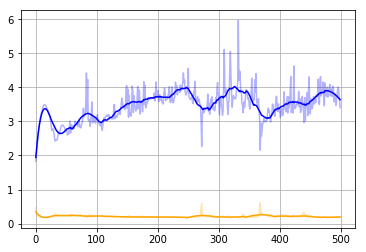

In [21]:
plt.plot(np.array(log["g_loss"])[:,0], alpha=0.3,c="b")
plt.plot(log["d_loss"], alpha=0.3,c="orange")
plt.plot(src.smooth(np.array(log["g_loss"])[:,0]),c="b")
plt.plot(src.smooth(np.array(log["d_loss"])),c="orange")
plt.grid()
plt.show()

In [20]:
from scipy.signal import savgol_filter
def smooth(curve):
    return savgol_filter(curve, 51, 3)

In [ ]:
import numpy as np
a=np.zeros((4,4,4,4,4))

In [ ]:
a[:,:,:,:].shape